# Benchmark model - Pastdue180 - Timewise Exploration, calibration, test

This notebook uses as inputs the outputs from the pipeline ('05_preproc_pipeline_1.ipynb' notebook) and performs model calibration and general exploration for the transaction credit events prediction.

In [1]:
import pandas as pd
import numpy as np
import pickle
from os import environ

from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scripts_viz.visualization_utils import *
from scripts_ml.models_utils import *

from bokeh.io import show, output_notebook
output_notebook()

import datetime as dt

Loading BokehJS ...

### TRAIN Data import

In [2]:
#importing data
prefix = 'time_2018-02-20_p180_'
trainfile = '_traindata'
testfile = '_testdata'
postfix = '_190710_745'
preproc_folder = "benchmarks_time"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix+trainfile+postfix+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix+testfile+postfix+'.pkl') 

In [3]:
y_train.shape

(42079,)

In [4]:
X_train_df = pd.DataFrame(X_train, columns=feature_labels)
X_train_df.head()

,has_purchase,dd_value_date,cd_lent_c,cd_repaid_c,cd_impaired1_c,cd_pastdue90_c,cd_trend_a,c_lent_c,c_repaid_c,c_impaired1_c,...,d_pastdue90_c,d_trend_a,d_we_payment_share,invoice_amount,purchase_amount,currency_Britisches Pfund,currency_Euro,currency_Schweizer Franken,currency_US-Dollar,invoice_date
0,-2.159842,0.529944,-0.613696,-0.507802,-0.190679,-0.168512,-0.027057,-1.029994,-0.871975,-0.659661,...,-0.177422,-0.014506,0.113441,-0.845072,-2.113268,0.0,0.0,1.0,0.0,-4.079018
1,-2.159842,0.529944,-0.604839,-0.507802,-0.190679,-0.168512,-0.027057,-1.028914,-0.871975,-0.659661,...,-0.177422,-0.014506,0.113441,-0.168021,-2.113268,0.0,0.0,1.0,0.0,-4.079018
2,-2.159842,0.529944,-0.595983,-0.507802,-0.190679,-0.168512,1.862478,-1.027835,-0.871975,-0.659661,...,-0.177422,1.880695,0.113441,-0.537961,-2.113268,0.0,0.0,1.0,0.0,-4.079018
3,-2.159842,0.529944,-0.613696,-0.507802,-0.190679,-0.168512,-0.027057,-1.029994,-0.871975,-0.659661,...,-0.177422,-0.014506,0.113441,0.903929,-2.113268,0.0,0.0,1.0,0.0,-4.079018
4,-2.159842,0.529944,-0.613696,-0.507802,-0.190679,-0.168512,-0.027057,-1.028914,-0.871975,-0.659661,...,-0.177422,-0.014506,0.113441,0.378387,-2.113268,0.0,0.0,1.0,0.0,-4.079018


In [5]:
X_train_df.columns

Index(['has_purchase', 'dd_value_date', 'cd_lent_c', 'cd_repaid_c',
       'cd_impaired1_c', 'cd_pastdue90_c', 'cd_trend_a', 'c_lent_c',
       'c_repaid_c', 'c_impaired1_c', 'c_pastdue90_c', 'c_trend_a',
       'cd_lent_c', 'd_repaid_c', 'd_impaired1_c', 'd_pastdue90_c',
       'd_trend_a', 'd_we_payment_share', 'invoice_amount', 'purchase_amount',
       'currency_Britisches Pfund', 'currency_Euro',
       'currency_Schweizer Franken', 'currency_US-Dollar', 'invoice_date'],
      dtype='object')

In [6]:
X_train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
has_purchase,42079.0,-3.785580e-09,1.000012,-2.159842,0.462997,0.462997,0.462997,0.462997
dd_value_date,42079.0,4.607500e-09,1.000012,-0.175457,-0.175457,-0.175457,-0.175457,78.521965
cd_lent_c,42079.0,8.322538e-09,1.000012,-0.613696,-0.569412,-0.445416,0.032852,4.092828
cd_repaid_c,42079.0,1.325477e-08,1.000012,-0.507802,-0.507802,-0.432611,-0.069188,4.266164
cd_impaired1_c,42079.0,-6.646897e-10,1.000012,-0.190679,-0.190679,-0.190679,-0.190679,7.726541
cd_pastdue90_c,42079.0,5.617815e-09,1.000012,-0.168512,-0.168512,-0.168512,-0.168512,8.287003
cd_trend_a,42079.0,1.856838e-09,1.000012,-3.726699,-0.699082,-0.027057,0.749816,3.676919
c_lent_c,42079.0,-1.004508e-08,1.000012,-1.029994,-0.805489,-0.357558,0.537225,2.888053
c_repaid_c,42079.0,8.975451e-09,1.000012,-0.871975,-0.803738,-0.379879,0.483585,3.209139
c_impaired1_c,42079.0,-6.203181e-09,1.000012,-0.659661,-0.659661,-0.524341,0.287580,4.292706


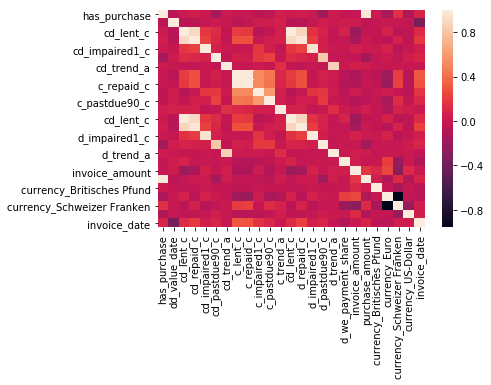

In [7]:
sns.heatmap(X_train_df.corr())

### SGD Classifier

In [9]:
#Linear model Stochastic Gradient Descent
sgd_clf = SGDClassifier(random_state=42, max_iter=250, loss='log', tol=0.0001) 
sgd_clf.fit(X_train, y_train)
sgd_clf_diag = model_diag_seq(sgd_clf, X_train, y_train, train_window=26000, test_window=2000)

Preparing fold 0 with 26079 train observations and 2000 test observations, starti=2079...
Fold 0: train  on 26079 from index 0 to 26078, test on 2000 from 26079 to 28078
Fold 0 AUC: 0.8057024335586861
Preparing fold 1 with 26000 train observations and 2000 test observations, starti=4079...
Fold 1: train  on 26000 from index 2079 to 28078, test on 2000 from 28079 to 30078
Fold 1 AUC: 0.48013898434066504
Preparing fold 2 with 26000 train observations and 2000 test observations, starti=6079...
Fold 2: train  on 26000 from index 4079 to 30078, test on 2000 from 30079 to 32078
Fold 2 AUC: 0.8083314286014539
Preparing fold 3 with 26000 train observations and 2000 test observations, starti=8079...
Fold 3: train  on 26000 from index 6079 to 32078, test on 2000 from 32079 to 34078
Fold 3 AUC: 0.6880857145597729
Preparing fold 4 with 26000 train observations and 2000 test observations, starti=10079...
Fold 4: train  on 26000 from index 8079 to 34078, test on 2000 from 34079 to 36078
Fold 4 AUC: 

In [10]:
y_score_sgd = sgd_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd)
print(cm)
sgd_test_diag = model_oostest(sgd_clf,X_test, y_test)
sgd_test_auc = plot_rocs([sgd_clf_diag, sgd_test_diag], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc)

[[15444    42]
 [   54     0]]
Confusion matrix: 
[[0.99729 0.00271]
 [0.00349 0.     ]]
AUC 0.839


In [8]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

In [12]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
# max Number of iterations
max_iter = [80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400] 
# learning rate
learning_rate = ['constant', 'optimal', 'adaptive']
#eta
eta0 = [0.00001, 0.0001, 0.001, 0.01]
#loss
loss = ['log', 'hinge', 'perceptron']

param_grid = {'max_iter': max_iter,
               'learning_rate': learning_rate,
                  'eta0': eta0,
                  'loss':loss}

sgd = SGDClassifier(tol=0.0001)

sgd_gsearch = GridSearchCV(estimator = sgd, param_grid = param_grid, #param_distributions = sgd_random_grid, 
                           cv = rolling_window(X_train.shape[0],ntrain = 26000, ntest = 2000, gen_for_grid_search=True),   
                                 verbose=2, n_jobs =-1, scoring=scoring, refit='AUC')
# Fit the random search model
sgd_gsearch.fit(X_train, y_train)

Preparing fold 0 with 26079 train observations and 2000 test observations, starti=2079...
Preparing fold 1 with 26000 train observations and 2000 test observations, starti=4079...
Preparing fold 2 with 26000 train observations and 2000 test observations, starti=6079...
Preparing fold 3 with 26000 train observations and 2000 test observations, starti=8079...
Preparing fold 4 with 26000 train observations and 2000 test observations, starti=10079...
Preparing fold 5 with 26000 train observations and 2000 test observations, starti=12079...
Preparing fold 6 with 26000 train observations and 2000 test observations, starti=14079...
Preparing fold 7 with 26000 train observations and 2000 test observations, starti=16079...
Fitting 8 folds for each of 612 candidates, totalling 4896 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4896 out of 4896 | elapsed:  6.4min finished


GridSearchCV(cv=<generator object rolling_window at 0x7ff8cd6444c0>,
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     ran...
             iid='warn', n_jobs=-1,
             param_grid={'eta0': [1e-05, 0.0001, 0.001, 0.01],
                         'learning_rate': ['constant', 'optimal', 'adaptive'],
                         'loss': ['log', 'hinge', 'perceptron'],
                         'max_iter': [80, 100, 120, 140, 160, 180, 200, 220,
                    

In [13]:
sgd_gsearch.best_params_

{'eta0': 0.0001, 'learning_rate': 'constant', 'loss': 'log', 'max_iter': 380}

In [7]:
#Linear model Stochastic Gradient Descent
sgd_gs = SGDClassifier(random_state=42, max_iter=380, loss='log', learning_rate='constant', eta0=0.0001, tol=0.0001) 
sgd_gs.fit(X_train, y_train)
sgd_gs_diag = model_diag_seq(sgd_gs, X_train, y_train,train_window=26000, test_window=2000)

Preparing fold 0 with 26079 train observations and 2000 test observations, starti=2079...
Fold 0: train  on 26079 from index 0 to 26078, test on 2000 from 26079 to 28078
Fold 0 AUC: 0.8237967544157823
Preparing fold 1 with 26000 train observations and 2000 test observations, starti=4079...
Fold 1: train  on 26000 from index 2079 to 28078, test on 2000 from 28079 to 30078
Fold 1 AUC: 0.46314348835357244
Preparing fold 2 with 26000 train observations and 2000 test observations, starti=6079...
Fold 2: train  on 26000 from index 4079 to 30078, test on 2000 from 30079 to 32078
Fold 2 AUC: 0.8711061369147547
Preparing fold 3 with 26000 train observations and 2000 test observations, starti=8079...
Fold 3: train  on 26000 from index 6079 to 32078, test on 2000 from 32079 to 34078
Fold 3 AUC: 0.6898378623796597
Preparing fold 4 with 26000 train observations and 2000 test observations, starti=10079...
Fold 4: train  on 26000 from index 8079 to 34078, test on 2000 from 34079 to 36078
Fold 4 AUC: 

In [8]:
y_score_sgd_gs = sgd_gs.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd_gs)
print(cm)
sgd_test_diag_gs = model_oostest(sgd_gs,X_test, y_test)
sgd_test_auc_gs = plot_rocs([sgd_gs_diag, sgd_test_diag_gs], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc_gs)

[[15157   329]
 [   52     2]]
Confusion matrix: 
[[0.97876 0.02124]
 [0.00336 0.00013]]
AUC 0.831


### Random Forest Classifier

In [14]:
#random forest - benchmark
n_estimators = 200
max_leaf_nodes = 40
rf_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                               max_leaf_nodes=max_leaf_nodes,
                               class_weight="balanced",
                               n_jobs=7)

rf_clf.fit(X_train, y_train)
rf_clf_diag = model_diag_seq(rf_clf, X_train, y_train,train_window=12000, test_window=3000)

Preparing fold 0 with 12079 train observations and 3000 test observations, starti=3079...
Fold 0: train  on 12079 from index 0 to 12078, test on 3000 from 12079 to 15078
Fold 0 AUC: 0.33573270168876823
Preparing fold 1 with 12000 train observations and 3000 test observations, starti=6079...
Fold 1: train  on 12000 from index 3079 to 15078, test on 3000 from 15079 to 18078
Fold 1 AUC: 0.839514
Preparing fold 2 with 12000 train observations and 3000 test observations, starti=9079...
Fold 2: train  on 12000 from index 6079 to 18078, test on 3000 from 18079 to 21078
Fold 2 AUC: 0.7267648526635686
Preparing fold 3 with 12000 train observations and 3000 test observations, starti=12079...
Fold 3: train  on 12000 from index 9079 to 21078, test on 3000 from 21079 to 24078
Fold 3 AUC: 0.8230265028800205
Preparing fold 4 with 12000 train observations and 3000 test observations, starti=15079...
Fold 4: train  on 12000 from index 12079 to 24078, test on 3000 from 24079 to 27078
Fold 4 AUC: 0.931899

In [15]:
y_score_rf = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf)
print(cm)
rf_test_diag = model_oostest(rf_clf,X_test, y_test)
rf_test_auc = plot_rocs([rf_clf_diag, rf_test_diag], p_width=600, p_height=600, model_appendix=['RF - seq_valid','RF - test'])
show(rf_test_auc)

[[13231  2255]
 [   38    16]]
Confusion matrix: 
[[0.85438 0.14562]
 [0.00245 0.00103]]
AUC 0.700


### Randomized Grid Search

In [9]:
# Number of trees in random forest
n_estimators = [60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 350] 
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 5, 10, 15, 20]
# Maximum number of levels in tree
max_depth = [20, 60, 90, 120, 150, 200, None]
#Max leaf nodes
max_leaf_nodes = [5,20,60,80]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [10]:
param_space = 1
for k in random_grid.keys():
    param_space*=len(random_grid[k])
    
print("Parameters space of {} different candidates".format(param_space))

Parameters space of 100800 different candidates


In [11]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2000, 
                               cv = rolling_window(X_train.shape[0],ntrain = 26000, ntest = 2000, gen_for_grid_search=True), 
                               verbose=2, random_state=42, n_jobs =-1, refit='AUC', scoring=scoring)
# Fit the random search model
rf_random.fit(X_train, y_train)

Preparing fold 0 with 26079 train observations and 2000 test observations, starti=2079...
Preparing fold 1 with 26000 train observations and 2000 test observations, starti=4079...
Preparing fold 2 with 26000 train observations and 2000 test observations, starti=6079...
Preparing fold 3 with 26000 train observations and 2000 test observations, starti=8079...
Preparing fold 4 with 26000 train observations and 2000 test observations, starti=10079...
Preparing fold 5 with 26000 train observations and 2000 test observations, starti=12079...
Preparing fold 6 with 26000 train observations and 2000 test observations, starti=14079...
Preparing fold 7 with 26000 train observations and 2000 test observations, starti=16079...
Fitting 8 folds for each of 2000 candidates, totalling 16000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 59.7min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 77.5min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 97.4min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 116.3min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 142.4min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 166.6min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 190.0min
[Parallel(n_jobs=-1)]: Done 9089 tasks    

RandomizedSearchCV(cv=<generator object rolling_window at 0x7f2f989664c0>,
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_l...
                                        'max_features': ['auto', 'sqrt',

In [13]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 120,
 'max_features': 'sqrt',
 'max_leaf_nodes': 80,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 260}

In [9]:
# Number of trees in random forest
n_estimators = [240, 250, 260, 270, 280] 
# Number of features to consider at every split
max_features = ['sqrt', 5, 7]
# Maximum number of levels in tree
max_depth = [110, 120, 130]
#Max leaf nodes
max_leaf_nodes = [70,80,90]
# Minimum number of samples required to split a node
min_samples_split = [3,5,6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [10]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, #param_distributions = sgd_random_grid, 
                           cv = rolling_window(X_train.shape[0],ntrain = 26000, ntest = 2000, gen_for_grid_search=True),   
                                 verbose=2, n_jobs =-1, scoring=scoring, refit='AUC')
# Fit the random search model
rf_grid.fit(X_train, y_train)

Preparing fold 0 with 26079 train observations and 2000 test observations, starti=2079...
Preparing fold 1 with 26000 train observations and 2000 test observations, starti=4079...
Preparing fold 2 with 26000 train observations and 2000 test observations, starti=6079...
Preparing fold 3 with 26000 train observations and 2000 test observations, starti=8079...
Preparing fold 4 with 26000 train observations and 2000 test observations, starti=10079...
Preparing fold 5 with 26000 train observations and 2000 test observations, starti=12079...
Preparing fold 6 with 26000 train observations and 2000 test observations, starti=14079...
Preparing fold 7 with 26000 train observations and 2000 test observations, starti=16079...
Fitting 8 folds for each of 1215 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 46.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 56.3min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 67.3min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 80.8min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 96.5min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 110.7min
[Parallel(n_jobs=-1)]: Done 9089 tasks      |

GridSearchCV(cv=<generator object rolling_window at 0x7f2830e5f780>,
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0....
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [110, 120, 130],
                         'max_features': ['sqrt', 5, 7],
                         'max_leaf_nodes': [70, 80, 90],
          

In [11]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 5,
 'max_leaf_nodes': 90,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 240}

In [12]:
#optimized params 
rf_opt = {'n_estimators': 240,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 90,
 'max_features': 5,
 'max_depth': 110,
 'bootstrap': True}

In [15]:
#random_forest from rand
n_estimators=rf_opt['n_estimators']
min_samples_split=rf_opt['min_samples_split']
min_samples_leaf=rf_opt['min_samples_leaf']
max_leaf_nodes=rf_opt['max_leaf_nodes']
max_features=rf_opt['max_features']
max_depth=rf_opt['max_depth']
bootstrap=rf_opt['bootstrap']




rf_opt_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                                max_features=max_features,
                                min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               class_weight="balanced", bootstrap=bootstrap,
                               n_jobs=7)
rf_opt_clf.fit(X_train, y_train)
rf_opt_diag = model_diag_seq(rf_opt_clf, X_train, y_train, train_window=26000, test_window=2000)

Preparing fold 0 with 26079 train observations and 2000 test observations, starti=2079...
Fold 0: train  on 26079 from index 0 to 26078, test on 2000 from 26079 to 28078
Fold 0 AUC: 0.9501265249084111
Preparing fold 1 with 26000 train observations and 2000 test observations, starti=4079...
Fold 1: train  on 26000 from index 2079 to 28078, test on 2000 from 28079 to 30078
Fold 1 AUC: 0.8971465736171621
Preparing fold 2 with 26000 train observations and 2000 test observations, starti=6079...
Fold 2: train  on 26000 from index 4079 to 30078, test on 2000 from 30079 to 32078
Fold 2 AUC: 0.9443069534536073
Preparing fold 3 with 26000 train observations and 2000 test observations, starti=8079...
Fold 3: train  on 26000 from index 6079 to 32078, test on 2000 from 32079 to 34078
Fold 3 AUC: 0.9508855060925505
Preparing fold 4 with 26000 train observations and 2000 test observations, starti=10079...
Fold 4: train  on 26000 from index 8079 to 34078, test on 2000 from 34079 to 36078
Fold 4 AUC: 0

In [16]:
y_score_rf_opt = rf_opt_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf_opt)
print(cm)
rf_opt_test_diag = model_oostest(rf_opt_clf,X_test, y_test)
rf_opt_test_auc = plot_rocs([rf_opt_diag, rf_opt_test_diag], p_width=600, p_height=600, model_appendix=['RF - val_seq','RF - test'])
show(rf_opt_test_auc)

[[15188   298]
 [   54     0]]
Confusion matrix: 
[[0.98076 0.01924]
 [0.00349 0.     ]]
AUC 0.636
